<a href="https://colab.research.google.com/github/thecognifly/CrashLandingExperiments/blob/master/CogniFly_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Experiment Notes and Data Processing

In [ ]:
# %config Completer.use_jedi = False 
# fix the autocomplete problem when using JupyterLab(https://github.com/ipython/ipython/issues/12740)

In [ ]:
!pip3 install git+git://github.com/ricardodeazambuja/ExecThatCell

In [ ]:
!git clone https://github.com/thecognifly/CrashLandingExperiments.git

In [ ]:
cd CrashLandingExperiments

In [ ]:
import os
import struct
import csv
import glob


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal

from IPython.display import display, Markdown

from execthatcell import execthatcell

In [ ]:
#
# Calibration results (from a total of 27 trials (13 Z up and 14 Z down))
#
# According to the self-test values in the datasheet, X and Y should
# have a G calibration value that is 0.96 of the one for Z.
#
Gz = 8.87700438
Gxy = Gz*0.9577
x_zero = 2019.93872
y_zero = 2020
z_zero = 2020.77284438

### Some info about the experiments
What we call here **SoftBottom** are experiments of [CogniFly (Carbon Fiber)](https://github.com/thecognifly/CogniFly-STL/tree/649340f9cae047e717b986510bd4be7e9a7c47d5) falling as if it was crash landing. we saved accelerometer data for falls on concrete (garage) from 50, 100 and 150cm. We tried to be as precise as possible to drop the drone from the correct altitude (and alignment) by using a big tripod with custom 3D printed parts as a template. However, it was done manually, so the drone didn't fall always the same way. That said, we consider this (small random variations) to be closer to reality, but maybe not as good for modelling. The drone weight was 241g in this configuration as we swapped the RPI+AIY+Camera for the Feather M0 Express+extra battery.

The experiments called **RigidBottom** were all dropped from 30cm (concrete floor, garage) because the accelerometer was saturing already at 50cm. The total weight was 239g and we used loose screws to approximatelly match the weight instead of the real CogniFly's battery to be safer. The screws were kept fairly loose (allowing some energy to be dissipated by friction), so they would not behave as a solid block of metal. We dropped it to hit flat on the battery holder, but, again, it was manual and not perfectly aligned.

Additionally, we saved accelerometer data for three experiments where the drone was dropped in another place and videos were recorded using the high speed camera. We took apart a pine table and dropped the drone on the table's top. The direction is **SoftBottom**, but the exp_dir needs to be manually set to "high_speed_camera_acc". Finally, the two first experiments were drops from 150cm and the last one from 262cm.
These last experiments had the battery connected the way it's normally used.

In [ ]:
#
# Experiment selection
#

# direction, m, height = "RigidBottom", 0.239, 30 # The only experiment at 30cm!

# direction, m, height = "SoftBottom", 0.241, 150 #50 100 150

# exp_dir = f"{direction}_{height}cm"

direction, exp_dir, m, height = "SoftBottom", "high_speed_camera_acc", 0.241, 262 # only the last experiment is for 262!


all_exp = glob.glob(exp_dir+"/*")
len(all_exp), all_exp[:10]

(3,
 ['high_speed_camera_acc/acc_f-3.bin',
  'high_speed_camera_acc/acc_f-1.bin',
  'high_speed_camera_acc/acc_f-2.bin'])

In [ ]:
#@#9
#
# Arduino version (running at 4kHz):
#
# Datalogger: https://gist.github.com/ricardodeazambuja/74c11b3f2ee806b1106625523a6b3812
#
experiments = {}
for ei in all_exp:
    index = ei.split("/")[1].split("_")[1].split(".")[0]
    letter, number = index.split('-')
    index = f"{letter}-{int(number):03}"
    values = []
    with open(ei, 'rb') as fp:
        while True:
            data = fp.read(10)
            if (not data) or (len(data)<10):
                break
            values.append(struct.unpack('<IHHH',data)) # 4+3x2=10
    experiments[index] = np.array(values)

In [ ]:
#@#10
keys = list(experiments.keys())
keys.sort()
len(keys)

3

In [ ]:
keys[:5]

['f-001', 'f-002', 'f-003']

In [ ]:
trial = 2

In [ ]:
values = experiments[keys[trial]]
keys[trial]

'f-003'

In [ ]:
# sample period (us)
((values[-1,0]-values[0,0]))/values.shape[0]

999.486125385406

In [ ]:
# total time (s)
(values[-1,0]-values[0,0])/1E6

1.945

In [ ]:
#@#12
diffs = (values[1:,0]-values[:-1,0])

In [ ]:
#@#13
c, v, _ = plt.hist(1/(diffs/1E6), bins=50)
plt.xlabel("Frequency [Hz]")
plt.title(f"Sample Rates (histrogram) for one experiment (Trial {trial})")
# plt.show()
plt.close()

In [ ]:
#@#14
fs = v[np.argmax(c)]
fs

1000.0

In [ ]:
#@#15
t = (values[:,0]-values[0,0])/1E6

In [ ]:
t[-1], t.shape

(1.945, (1946,))

In [ ]:
#@#17

#
# Estimated speed at collision (m/s)
#
g = 9.81

v_collision_hat = np.sqrt(2*g*height/100)
v_collision_hat

7.169686185601153

In [ ]:
#@#18

#
# Estimated total fall time (s)
# 
#
delta_x = height/100
t_fall_hat = np.sqrt(2*delta_x/g)
t_fall_hat

0.7308548609175487

In [ ]:
#@#19

#
# Estimated total fall time in steps
#
t_fall_steps_hat = int(t_fall_hat/(1/fs))
t_fall_steps_hat

730

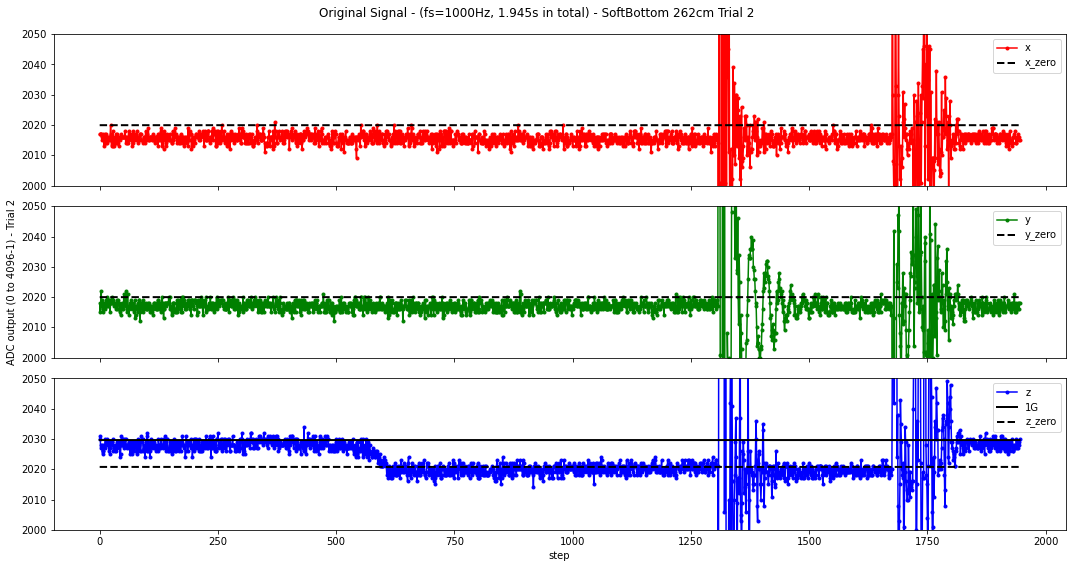

In [ ]:
fig,ax = plt.subplots(3,1,sharex=True, sharey=False,figsize=(15,8))

ax[0].plot(values[:,1],'r.-', label="x")
ax[0].plot([x_zero]*len(t),'k--',linewidth=2, label="x_zero")
ax[0].legend()
ax[0].set_ylim(2000,2050)

ax[1].plot(values[:,2],'g.-', label="y")
ax[1].plot([y_zero]*len(t),'k--',linewidth=2, label="y_zero")
ax[1].legend()
ax[1].set_ylim(2000,2050)
ax[1].set_ylabel(f"ADC output (0 to 4096-1) - Trial {trial}")

ax[2].plot(values[:,3],'b.-', label="z")
ax[2].plot([z_zero+Gz]*len(t),'k-',linewidth=2, label="1G")
ax[2].plot([z_zero]*len(t),'k--',linewidth=2, label="z_zero")
ax[2].set_xlabel("step")
ax[2].legend()
ax[2].set_ylim(2000,2050)

plt.suptitle(f"Original Signal - (fs={int(fs)}Hz, {t[-1]}s in total) - {direction} {height}cm Trial {trial}")
plt.tight_layout()
plt.show()

In [ ]:
#@#21

values_shifted = (values[:,1:]-[x_zero,y_zero,z_zero])/[Gxy,Gxy,Gz]

abs(values_shifted).max(axis=0), abs(values).max(axis=0)

(array([ 97.04882567,  85.86712825, 183.30813932]),
 array([5067000,    2845,    2750,    3648]))

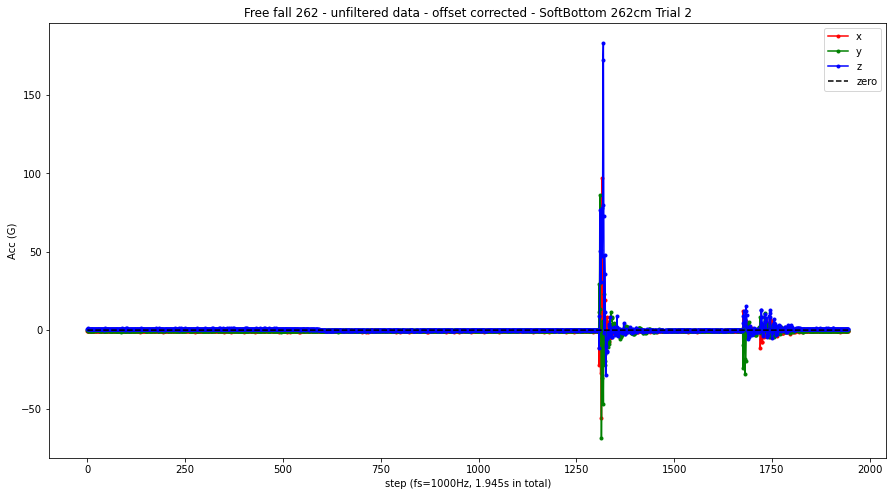

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(values_shifted[:,0],'r.-', label="x")
plt.plot(values_shifted[:,1],'g.-', label="y")
plt.plot(values_shifted[:,2],'b.-', label="z")
plt.plot([0]*values[:,3].shape[0],'k--', label="zero")
plt.title(f"Free fall {height} - unfiltered data - offset corrected - {direction} {height}cm Trial {trial}")
plt.xlabel(f"step (fs={int(fs)}Hz, {t[-1]}s in total)")
plt.ylabel("Acc (G)")
plt.legend()
# plt.ylim(-2,2)
# plt.xlim(12000,14000)
plt.show()

In [ ]:
#@#23

from scipy import signal

highcut = 250

order = 9

nyq = 0.5 * fs
high = highcut / nyq


b_butter, a_butter = signal.butter(order, high, btype='lowpass')
values_filtered = np.zeros(values_shifted.shape)
for i in range(3):
    y = values_shifted[:,i]
    values_filtered[:,i] = signal.filtfilt(b_butter, a_butter, y, method="gust")

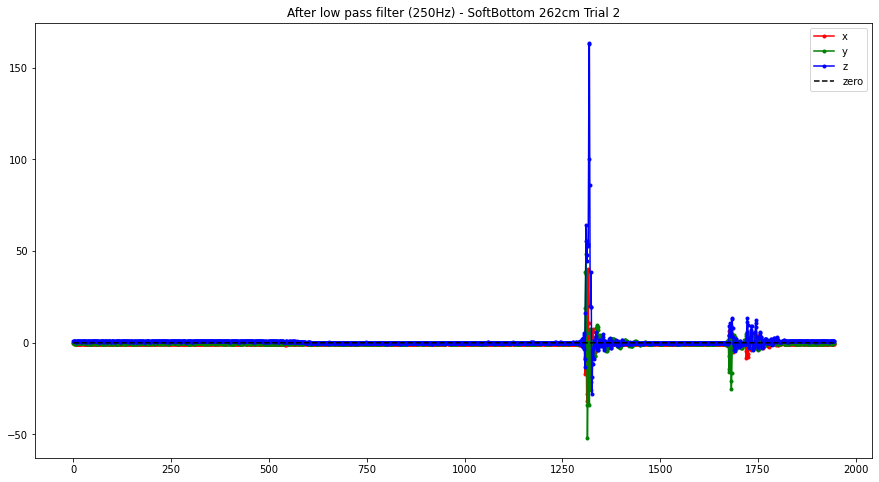

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(values_filtered[:,0],'r.-', label="x")
plt.plot(values_filtered[:,1],'g.-', label="y")
plt.plot(values_filtered[:,2],'b.-', label="z")
plt.plot([0]*values[:,3].shape[0],'k--', label="zero")

plt.title(f"After low pass filter ({highcut}Hz) - {direction} {height}cm Trial {trial}")
plt.legend()

plt.show()

In [ ]:
#@#25

resultant_rawacc = np.sqrt((values_shifted**2).sum(axis=1))

resultant_acc = resultant_rawacc

resultant_acc.max()

189.30310427462138

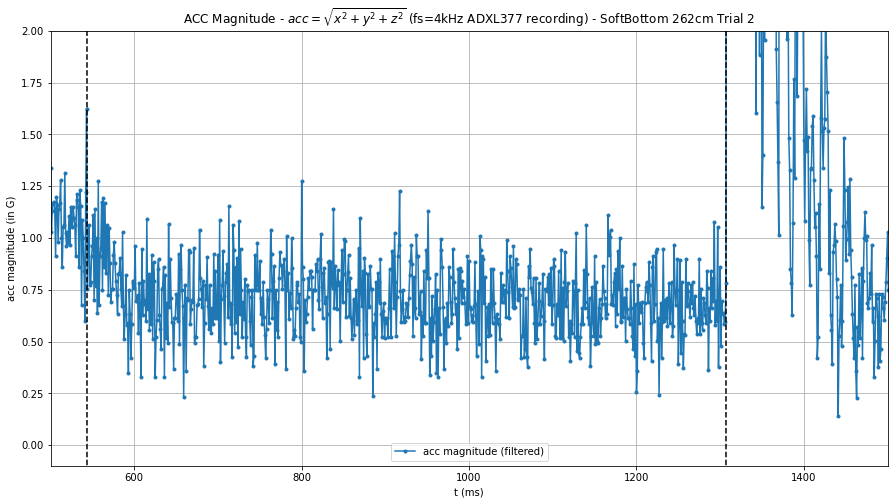

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(resultant_acc,'.-', label="acc magnitude (filtered)")

plt.ylabel("acc magnitude (in G)")
plt.xlabel("t (ms)")
plt.title(f"ACC Magnitude - $acc=\sqrt{{x^2+y^2+z^2}}$ (fs=4kHz ADXL377 recording) - {direction} {height}cm Trial {trial}")
plt.legend()


plt.plot([543]*10,np.linspace(-5,20,10),'k--')
plt.plot([1307]*10,np.linspace(-5,20,10),'k--')
plt.ylim(-0.1, 2)
plt.xlim(500,1500)

plt.grid()
plt.show()

(-10.0, 5.0)

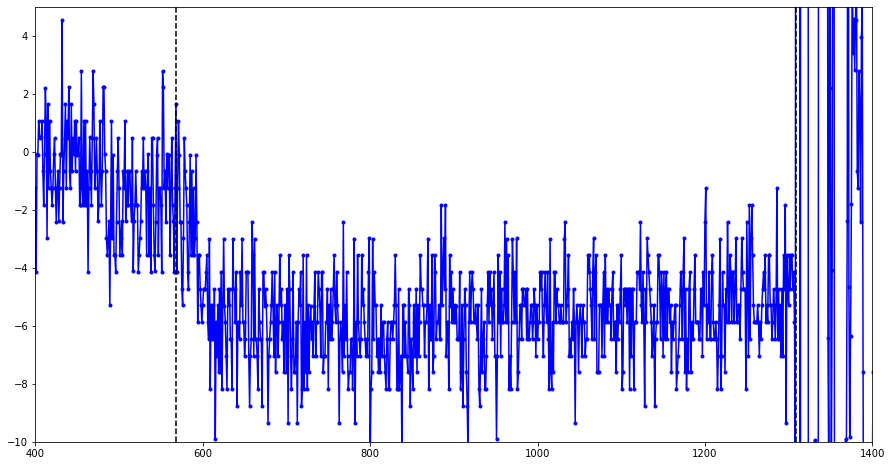

In [ ]:
plt.figure(figsize=(15,8))
plt.plot((values[:,1:]**2).sum(axis=1)**(1/2)-3500,'b.-', label="z")
plt.plot([z_zero+Gz]*len(t),'k-',linewidth=2, label="1G")
plt.plot([z_zero]*len(t),'k--',linewidth=2, label="z_zero")

plt.plot([568]*10,np.linspace(-10,35,10),'k--')
plt.plot([1309]*10,np.linspace(-10,35,10),'k--')

plt.xlim(400,1400)
plt.ylim(-10,5)

In [ ]:
fall_time_262_trial_0 = (1309-568)*(1/fs)
fall_time_262_trial_0
# fall_time_150_trial_0 = (1515-940)*(1/fs)
# fall_time_150_trial_0

0.741

In [ ]:
fall_time_plot = fall_time_262_trial_0
acc_mult = (2*2.62/fall_time_plot**2)/9.81
acc_mult

0.9728051557544504

In [ ]:
np.sqrt(2*2.62/(9.81*acc_mult))*(9.81*acc_mult) # max speed collision at 262cm considering drag

7.0715249662618085

In [ ]:
#@#27

#
# Find where the impact starts
#

# Start finding the first peak and let's consider it must be the beginning of the impact in a normal experiment

index_impact = np.argwhere(resultant_acc>3)[0,0] - 1 # I noticed it gets the first big value.
            
index_impact,t[index_impact]

(1307, 1.307)

In [ ]:
#@#28

#
# Find where the drop starts
#

# Use the estimation of time steps to calculate the mean value of free fall (magnitude is squared, so no real zero G) 
if (index_impact-int(t_fall_steps_hat)) > 0:
    sample_freefall = resultant_acc[index_impact-int(t_fall_steps_hat):index_impact]
else:
    sample_freefall = resultant_acc[0:index_impact]
std = (sample_freefall-sample_freefall.mean()).std()

for i in range(8,1,-1):
    index_drop = np.argwhere(resultant_acc[:index_impact]>(sample_freefall.mean()+i*std))
    if len(index_drop):
        index_drop = int(index_drop[-1,0])
        break

if not type(index_drop)==int:
    print(f"Couldn't find where the drop starts ({index_drop, index_impact})!")
    index_drop = 0

index_drop, t[index_drop]

(543, 0.543)

In [ ]:
#@#29

#
# Find the beginning of the free fall (zero G)
#

index_freefall = np.argwhere(abs(resultant_acc[index_drop:]-(sample_freefall.mean()-2*std))<0.1)


if len(index_freefall):
    index_freefall = index_freefall[0,0]
    index_freefall += index_drop
else:
    index_freefall = index_drop


index_freefall,t[index_freefall]

(593, 0.593)

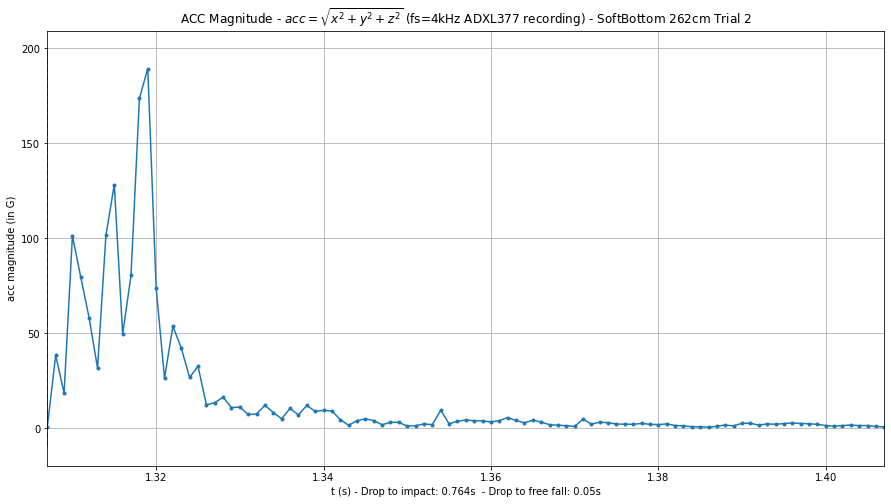

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(t,resultant_acc,'.-', label="acc magnitude")

yl,lh = plt.gca().get_ylim()
plt.plot([t[index_drop]]*10, np.linspace(yl,lh,10),'--', 
         label="Estimated drop")
plt.plot([t[index_freefall]]*10, np.linspace(yl,lh,10),'--', 
         label="Estimated fall start")
plt.plot([t[index_impact]]*10, np.linspace(yl,lh,10),'--', 
         label="Estimated collision start")

# plt.plot([0]*resultant_acc.shape[0],'-.', label="zero")
# plt.plot([1]*resultant_acc.shape[0],'-.', label="one")

plt.ylabel("acc magnitude (in G)")
plt.xlabel(f"t (s) - Drop to impact: {t[index_impact]-t[index_drop]:0.3}s  - Drop to free fall: {t[index_freefall]-t[index_drop]:0.3}s")
plt.title(f"ACC Magnitude - $acc=\sqrt{{x^2+y^2+z^2}}$ (fs=4kHz ADXL377 recording) - {direction} {height}cm Trial {trial}")
# plt.legend()

# plt.xlim(t[index_drop]-.1,t[index_impact]+0.1)
plt.xlim(t[index_impact],t[index_impact]+0.1)
# plt.ylim(-5,5)

# plt.xlim(1.7, 1.8)
# x_ticks = np.linspace(1.105, 1.13, 15)
# plt.xticks(x_ticks)
# y_ticks = np.linspace(0, 110, 20)
# plt.yticks(y_ticks)

plt.grid()
plt.show()

In [ ]:
index_peak = np.argmax(resultant_acc)
t[index_peak], (t[index_peak]-t[index_impact])/(1/960) # peak time and how many video frames from impact to peak

(1.319, 11.52000000000001)

In [ ]:
t[index_impact]-t[index_drop], t[index_freefall]-t[index_drop]

(0.7639999999999999, 0.04999999999999993)

In [ ]:
# display(Markdown(f"""# ...Working on *{direction}*, height *{height}*, weight *{m}kg*, low-pass at *{highcut}Hz*"""))

### Menu: Cell=>Run All Above
#### The cells below will automatically process the data, but you need to run all the cell above at least once

In [ ]:
#
# Experiment selection
#

# direction, m, height = "SoftBottom", 0.241, 50
# direction, m, height = "SoftBottom", 0.241, 100
# direction, m, height = "SoftBottom", 0.241, 150

# direction, m, height = "RigidBottom", 0.239, 30 # The only experiment at 30cm!

# exp_dir = f"{direction}_{height}cm"
# all_exp = glob.glob(exp_dir+"/*")



#
# Uncomment the lines below for reading the high speed camera fall experiment from 262cm
#
direction, exp_dir, m, height = "SoftBottom", "high_speed_camera_acc", 0.241, 262 # only the last experiment is for 262!
all_exp = glob.glob(exp_dir+"/*")
all_exp.sort()
all_exp = [all_exp[-1]]


len(all_exp)

1

In [ ]:
# or it will not close the plots when using my current version of jupyter-lab...
%matplotlib inline 


# import traceback  # useful to give extra info on exceptions


event_indices = []
resultant_accs = []
individual_acc = []
t_rec = []
max_axis = []
cell_list = [12, 13, 14, 15, 17, 18, 19, 21, 23, 25, 27, 28, 29]

# First load the data files (9) and sort the keys (10)
for i in [9,10]:
    try:
        exec(In[execthatcell(str(i), exec_it=False)])
    except Exception as exc_err:
        print(i, exc_err)


for ki,key in enumerate(keys):
    values = experiments[key]
    for i in cell_list:
        try:
            exec(In[execthatcell(str(i), exec_it=False)])
        except Exception as exc_err:
            print(i, ki, key, exc_err)
            # Uncomment lines below to improve debugging in case of errors
            #print(traceback.format_exc())
            #print(traceback.print_stack())
            
    event_indices.append([index_drop, index_freefall, index_impact])
    
    resultant_accs.append(resultant_rawacc) # using raw acc magnitude values
    individual_acc.append(values_shifted)
    max_axis.append(max(abs(values_shifted).max(axis=0)))
    
    t_rec.append(t)
    
    
print(len(resultant_accs))

1


In [ ]:
#
# Cut the end of the experiments to make sure they are all the same
# because the datalogger was manually started and after that I would drop the drone manually as well.
# Possible problem: if one of the experiments is abnormally too short...

trimmed_accs = []
trimmed_ind_accs = []
min_length = 10000000
time_indices = []
for ids, res, indiv in zip(event_indices, resultant_accs, individual_acc):
    index_drop, index_freefall, index_impact = ids
    time_indices.append(ids)
    trimmed_accs.append(res[index_impact:])
    trimmed_ind_accs.append(indiv[index_impact:,:])
    min_length = min(min_length,len(trimmed_accs[-1]))
    
final_mag_accs = np.zeros((len(trimmed_accs), min_length))
for i,acc in enumerate(trimmed_accs):
    final_mag_accs[i,:] = acc[:min_length]
    
final_accs_x = np.zeros((len(trimmed_accs), min_length))
final_accs_y = np.zeros((len(trimmed_accs), min_length))
final_accs_z = np.zeros((len(trimmed_accs), min_length))
for i,acc in enumerate(trimmed_ind_accs):
    final_accs_x[i,:] = acc[:min_length,0]
    final_accs_y[i,:] = acc[:min_length,1]
    final_accs_z[i,:] = acc[:min_length,2]


# Filter outliers (discards everything that is smaller than, not bigger)
# I'm discarding the smaller ones because sometimes the experiments may have a bug like me dropping too late, etc.

nstd = 6
max_peaks = final_mag_accs.max(axis=1)
min_peak = np.mean(max_peaks)-nstd*np.std(max_peaks)
NofSamples_init = final_mag_accs.shape[0]
acc_inliers = np.argwhere(max_peaks>=min_peak).flatten()
final_mag_accs = final_mag_accs[acc_inliers,:]

print(min_peak, NofSamples_init, final_mag_accs.shape[0])

189.30310427462138 1 1


In [ ]:
# Here I'm calculating the time delay during the drop
# I want to use it for system identification
t_falls = (np.array(time_indices)*(1/fs))
(t_falls[:,1]-t_falls[:,0]).mean()

0.04999999999999993

In [ ]:
np.savetxt(f"magnitude_accelerations_{direction}_{height}cm_{int(m*1000)}g_fs_{int(fs/1000)}kHz.csv",final_mag_accs)
np.savetxt(f"event_indices_{direction}_{height}cm_{int(m*1000)}g_fs_{int(fs/1000)}kHz.csv",event_indices)
np.savetxt(f"accelerations_x_{direction}_{height}cm_{int(m*1000)}g_fs_{int(fs/1000)}kHz.csv",final_accs_x)
np.savetxt(f"accelerations_y_{direction}_{height}cm_{int(m*1000)}g_fs_{int(fs/1000)}kHz.csv",final_accs_y)
np.savetxt(f"accelerations_z_{direction}_{height}cm_{int(m*1000)}g_fs_{int(fs/1000)}kHz.csv",final_accs_z)

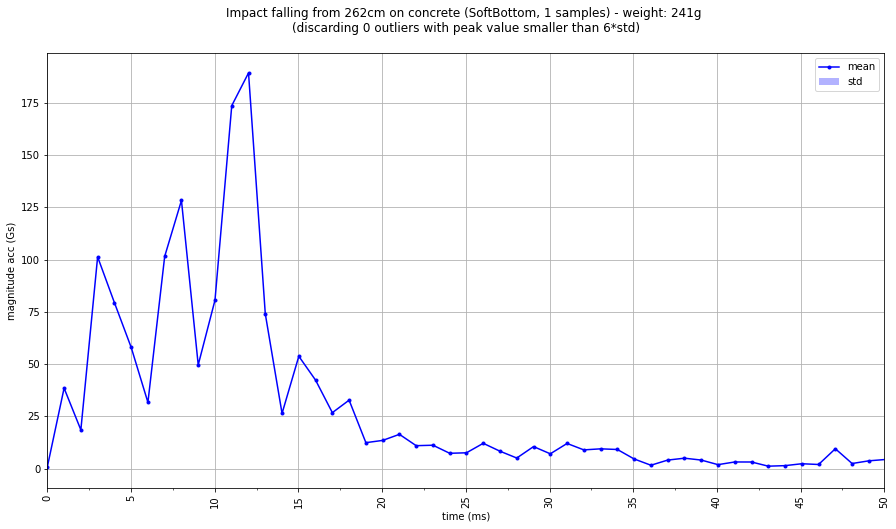

In [ ]:
import matplotlib.ticker as plticker

meanplusstd = np.mean(final_mag_accs, axis=0)+np.std(final_mag_accs, axis=0)
meanminusstd = [max(0,i) for i in (np.mean(final_mag_accs, axis=0)-np.std(final_mag_accs, axis=0))]

t = np.linspace(0,final_mag_accs.shape[1]*(1/fs), final_mag_accs.shape[1])
plt.figure(figsize=(15,8))
# plt.plot(t*1000,np.mean(avg_accs, axis=1)+np.std(avg_accs, axis=1), label="mean+std")
plt.gca().fill_between(t*1000, meanplusstd, 
                               meanminusstd, 
                               facecolor='blue', alpha=0.3, label="std")
plt.plot(t*1000,np.mean(final_mag_accs, axis=0),'b.-', label="mean")

# plt.plot(t*1000,[np.mean(final_mag_accs, axis=0)[0]]*len(t),'--', label="lowest point for magnitude")

plt.xlim(0,50)
# plt.ylim(-0.5,5)
plt.xlabel("time (ms)")
plt.ylabel("magnitude acc (Gs)")
plt.title(f"Impact falling from {height}cm on concrete ({direction}, {NofSamples_init} samples) - weight: {int(m*1000)}g \n(discarding {NofSamples_init-final_mag_accs.shape[0]} outliers with peak value smaller than {nstd}*std)\n")
plt.legend()

plt.gca().xaxis.set_major_locator(plticker.MultipleLocator(5))
plt.gca().xaxis.set_minor_locator(plticker.MultipleLocator(2.5))

for label in plt.gca().xaxis.get_ticklabels():
    # label is a Text instance
    # label.set_color('tab:red')
    label.set_rotation(90)
    # label.set_fontsize(16)

plt.gca().grid()

plt.savefig(f"accelerations_{direction}_{height}cm_{int(m*1000)}g_fs_{int(fs/1000)}kHz.pdf")

plt.show()

### Inspect individual experiments using the interactive plot:

In [ ]:
from ipywidgets import interactive
from matplotlib.ticker import StrMethodFormatter

axis_index = {'x':0,'y':1,'z':2}
def f(i, mag=True, axis='z'):
    idx_trans = 200
    plt.figure(figsize=(15,8))
    index_drop, index_freefall, index_impact = event_indices[i]
    if mag:
        plt.plot(t_rec[i][index_impact:]-t_rec[i][index_impact],
                 resultant_accs[i][index_impact:], '.-')
    else:
        plt.plot(t_rec[i][index_impact:]-t_rec[i][index_impact],
                 individual_acc[i][index_impact:,axis_index[axis]], '.-')
        
    plt.xlim(0, 0.1)
    
    
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:05.1f}')) # No decimal places
    plt.title(f"""Impact falling from {height}cm on concrete ({direction}, {NofSamples_init} samples) - weight: {int(m*1000)}g
    Max value measured (axis): {max_axis[i]:.5} - {keys[i]}
    Max Acc{axis.upper()} value: {individual_acc[i][index_impact:,axis_index[axis]].max():.3f}""")

    if mag:
        xticks = np.linspace(0, plt.gca().get_xlim()[1], 30)
        yticks = np.linspace(0, plt.gca().get_ylim()[1], 20)

        plt.xticks(xticks, rotation=90)
        plt.yticks(yticks)
    
    plt.grid(which='both')
    plt.show()

interactive_plot = interactive(f, i=(0, len(resultant_accs)-1), axis=['x','y','z'])
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
interactive_plot

### Non-interactive plot of individual experiments:

In [ ]:
i = 67 #c-76
plt.figure(figsize=(15,8))
index_drop, index_freefall, index_impact = event_indices[i]
# plt.plot(t_rec[i][index_freefall:],resultant_accs[i][index_freefall:])
plt.plot(t_rec[i],resultant_accs[i])
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:05.1f}')) # No of decimal places
plt.xlim(1.2,2)
plt.grid()
plt.show()

# Optimization to fit the mass-spring-damper model to the experimental data

In [ ]:
from scipy.optimize import curve_fit, least_squares
from scipy import interpolate

import numpy as np
import matplotlib.pyplot as plt


m = .241
g = 9.81
fs = 1000
x_collision = 16
LP_FILTER = 500

In [ ]:
from scipy import signal
from scipy.integrate import quad

def x_ss_cont(t, c, k, altitude, m, g=9.81):
    A = np.array([[0, 1], [-k/m, -c/m]])
    B = np.array([[0],[g]])
    C = np.array([1, 0])
    D = np.array([[0]])
    sys = signal.StateSpace(A, B, C, D)
    
    t, y, x = signal.lsim(sys, U=np.ones(len(t)), T=t, X0=[0,np.sqrt(2*g*altitude)])

    return y

def v_ss_cont(t, c, k, altitude, m, g=9.81):
    A = np.array([[0, 1], [-k/m, -c/m]])
    B = np.array([[0],[g]])
    C = np.array([1, 0])
    D = np.array([[0]])
    sys = signal.StateSpace(A, B, C, D)
    
    t, y, x = signal.lsim(sys, U=np.ones(len(t)), T=t, X0=[0,np.sqrt(2*g*altitude)])

    return x[:,1]

def a_ss_cont(t, c, k, altitude, m, g=9.81):
    A = np.array([[0, 1], [-k/m, -c/m]])
    B = np.array([[0],[g]])
    C = np.array([1, 0])
    D = np.array([[0]])
    sys = signal.StateSpace(A, B, C, D)
    t, y, x = signal.lsim(sys, U=np.ones(len(t)), T=t, X0=[0,np.sqrt(2*g*altitude)])
    
    return x.dot([-k/m, -c/m])+g


def k_energy_ss_cont(t, c, k, altitude, m, g=9.81):
    A = np.array([[0, 1], [-k/m, -c/m]])
    B = np.array([[0],[g]])
    C = np.array([1, 0])
    D = np.array([[0]])
    sys = signal.StateSpace(A, B, C, D)
    t, y, x = signal.lsim(sys, U=np.ones(len(t)), T=t, X0=[0,np.sqrt(2*g*altitude)])
    
    return abs(0.5*(x**2).dot([k, 0]))

In [ ]:
def func_fit(t,c,k,altitude,m=0.241,g=9.81,lp_cut=1000):
    
    yout = abs(a_ss_cont(t,c,k,altitude=altitude/100,m=m,g=g))
    
    
    if lp_cut<1000:
        #lti = signal.lti([1], [1/lp_cut**3, 2/lp_cut**2, 2/lp_cut, 1]) # butterworth order=3

        #lti = signal.lti([lp_cut**2], [1, lp_cut*np.sqrt(2),lp_cut**2]) # butterworth order=2
    
        lti = signal.lti([lp_cut], [1,lp_cut]) # butterworth order=1

        tout, yout, xout = signal.lsim(lti, U=yout, T=t)

    
    return yout

### Lumped Mass-Spring-Damper model


The data was collected using an Adafruit breakout board with the ADLX377 $\pm200g$ 3-axis 500MHz bandwidth analog accelerometer in conjuction with the Feather M0 Express (2MB SPI Flash) using [a custom Arduino Sketch](https://gist.github.com/ricardodeazambuja/74c11b3f2ee806b1106625523a6b3812) to digitalize the experimental data at 1KHz.

In the light of covid-19 pandemic, all the experiments were carried out at home, so some simplifications were made necessary. The UAV was manually dropped directly on the garage's concrete floor and a tripod was used to align it to guarantee the initial altitude was repeated. Our custom datalogger was able to save up to 100 trials of 120s, but some trials were missed (and ignored in our analysis) because the drone was dropped too late and the record stopped before the collision occurred.

The breakout board with the ADLX377 has capacitors that that limit its max bandwidth to 500Hz and, therefore, the optimization problem designed to fit the data to the model uses a 1st order Butterworth filter at 500MHz to mimic that behaviour. 

#### Jump to [c,k-countour-plot](#c,k-countour-plot) for the optimization.

## Checking model

In [ ]:
cm, km = 46, 7040 # Values at the end of the 

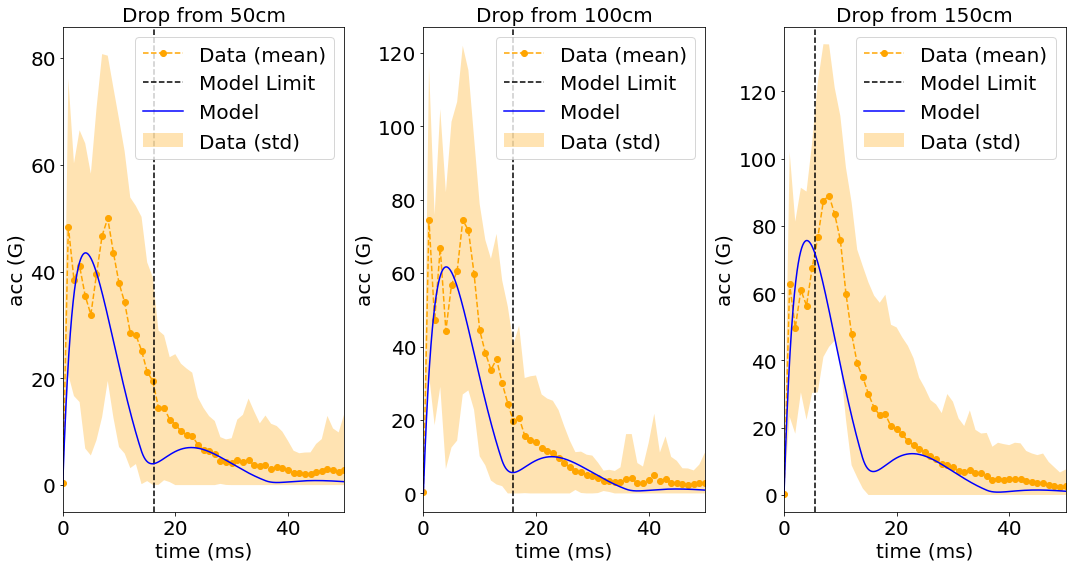

In [ ]:
SHOW_ALL = True # controls whether the plot will go until the max valid displacement or not

direction, m = "SoftBottom", 0.241

t_plot = np.linspace(0,50/1000,3000)

plt.figure(figsize=(15,8))
for i,h in enumerate([50,100,150]): # reads the data from all experiments, but this data starts at 
                                    # the point when the drone touches the floor
    max_index = np.argmax(x_ss_cont(t_plot,cm,km,altitude=h/100,m=m))*(1+10*SHOW_ALL)
    t_plot = t_plot[:max_index+1]
    plt.subplot(1,3,i+1)
    resultant_accs = np.loadtxt(f"magnitude_accelerations_{direction}_{h}cm_{int(m*1000)}g_fs_{int(fs/1000)}kHz.csv")
    meanplusstd = np.mean(resultant_accs, axis=0)+np.std(resultant_accs, axis=0)
    meanminusstd = [max(0,i) for i in (np.mean(resultant_accs, axis=0)-np.std(resultant_accs, axis=0))]
    mean_data = resultant_accs.mean(axis=0)
    plt.gca().fill_between(np.arange(len(mean_data)), 
                           meanplusstd, 
                           meanminusstd, 
                           facecolor='orange', alpha=0.3, label=f"Data (std)")
    plt.plot(np.arange(len(mean_data)), mean_data, 'o--', c='orange', label=f"Data (mean)")
    
    final_index = {}
    if SHOW_ALL:
        max_index_tmp = np.argmax(x_ss_cont(t_plot,cm,km,altitude=h/100,m=m))
        if any(1000*x_ss_cont(t_plot,cm,km,altitude=h/100,m=m)[:max_index_tmp] > x_collision):
            # The model is valid until the base of the battery holder touches the floor
            max_index_tmp = np.where(1000*x_ss_cont(t_plot,cm,km,altitude=h/100,m=m)[:max_index_tmp]<=16)[0][-1]
        else:
            # The model is valid until the frame is touching the floor
            max_index_tmp = np.where(1000*x_ss_cont(t_plot,cm,km,altitude=h/100,m=m)[max_index_tmp:]<=0)[0][0]
            
        final_index[h] = np.where(1000*x_ss_cont(t_plot,cm,km,altitude=h/100,m=m)[:max_index]<=16)[0][-1]
        
        plt.plot([1000*t_plot[max_index_tmp]]*2, [-5, max(meanplusstd)+5], 'k--', label=f"Model Limit")
    else:
        if any(1000*x_ss_cont(t_plot,cm,km,altitude=h/100,m=m)[:max_index] > x_collision):
            final_index[h] = np.where(1000*x_ss_cont(t_plot,cm,km,altitude=h/100,m=m)[:max_index]<=16)[0][-1]
        else:
            final_index[h] = np.argmax(1000*x_ss_cont(t_plot,cm,km,altitude=h/100,m=m)[:max_index])    
            
    plt.plot(t_plot[:final_index[h]]*1000, func_fit(t_plot[:final_index[h]],cm,km,lp_cut=LP_FILTER,altitude=h,m=m)/9.81, 'b-', label=f"Model")
    

    plt.legend(fontsize=20)
    plt.title(f"Drop from {h}cm", fontsize=20)
    plt.xlabel("time (ms)", fontsize=20)
    plt.ylabel(f"acc (G)", fontsize=20)
    plt.xlim(0,t_plot[final_index[h]]*1000)
    plt.ylim(-5,max(meanplusstd)+5)
    plt.gca().tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()

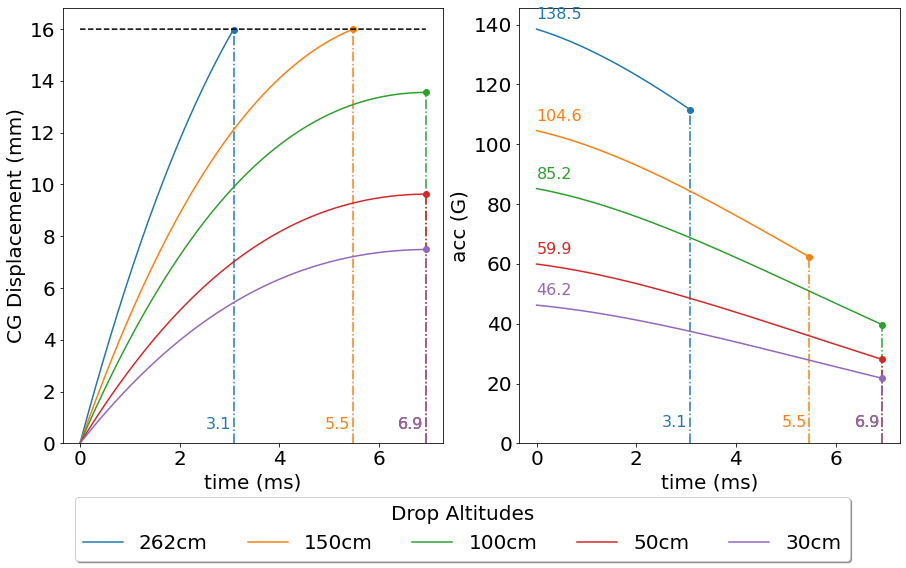

In [ ]:
t_plot = np.linspace(0,50/1000,10000)

altitudes = [30, 50, 100, 150, 262][::-1]


final_index = {}
for h in altitudes:
    max_index = np.argmax(x_ss_cont(t_plot,cm,km,altitude=h/100,m=m))
    t_plot = t_plot[:max_index+1]
    if any(1000*x_ss_cont(t_plot,cm,km,altitude=h/100,m=m)[:max_index] > x_collision):
        final_index[h] = np.where(1000*x_ss_cont(t_plot,cm,km,altitude=h/100,m=m)[:max_index]<=16)[0][-1]
    else:
        final_index[h] = np.argmax(1000*x_ss_cont(t_plot,cm,km,altitude=h/100,m=m)[:max_index])    

plt.figure(figsize=(15,8))
ax1 = plt.subplot(1,2,1)
for h in altitudes:
    max_index = np.argmax(x_ss_cont(t_plot,cm,km,altitude=h/100,m=m))
    t_plot = t_plot[:max_index+1]
    base_line, = ax1.plot(t_plot[:final_index[h]]*1000,1000*x_ss_cont(t_plot[:final_index[h]],cm,km,altitude=h/100,m=m), '-', label=f"{h}")
    plt.plot([t_plot[final_index[h]]*1000],[1000*x_ss_cont(t_plot[:final_index[h]],cm,km,altitude=h/100,m=m)[-1]], 'o', c=base_line.get_color())
    plt.plot([t_plot[final_index[h]]*1000]*2,[0, 1000*x_ss_cont(t_plot[:final_index[h]],cm,km,altitude=h/100,m=m)[-1]], '-.', c=base_line.get_color())

    plt.gca().annotate(f'{t_plot[final_index[h]]*1000:0.1f}',
                xy=(t_plot[final_index[h]]*1000, .5),
                xytext=(-28, 1),  # use 3 points offset
                textcoords="offset points",  # in both directions
                fontsize=16, c=base_line.get_color()
               )

    
plt.plot(t_plot*1000,[16]*t_plot.shape[0],'k--')
plt.xlabel("time (ms)", fontsize=20)
plt.ylabel("CG Displacement (mm)", fontsize=20)

plt.ylim(0)

ax2 = plt.subplot(1,2,2)
for h in altitudes:
    max_index = np.argmax(x_ss_cont(t_plot,cm,km,altitude=h/100,m=m))
    t_plot = t_plot[:max_index+1]
    base_line, = ax2.plot(t_plot[:final_index[h]]*1000, -a_ss_cont(t_plot[:final_index[h]],cm,km, altitude=h/100,m=m)/9.81, '-', label=f"{h}cm")
    plt.plot([t_plot[final_index[h]]*1000], [(-a_ss_cont(t_plot[:final_index[h]],cm,km, altitude=h/100,m=m)/9.81)[-1]], 'o', c=base_line.get_color())
    plt.plot([t_plot[final_index[h]]*1000]*2, [0,(-a_ss_cont(t_plot[:final_index[h]],cm,km, altitude=h/100,m=m)/9.81)[-1]], '-.', c=base_line.get_color())
    # https://stackoverflow.com/a/13831816
    
    plt.gca().annotate(f'{(-a_ss_cont(t_plot[:final_index[h]],cm,km, altitude=h/100,m=m)/9.81)[0]:0.1f}',
                xy=(0,(-a_ss_cont(t_plot[:final_index[h]],cm,km, altitude=h/100,m=m)/9.81)[0]),
                xytext=(0, 10),
                textcoords="offset points",  # in both directions
                fontsize=16, c=base_line.get_color()
               )
    
    plt.gca().annotate(f'{t_plot[final_index[h]]*1000:0.1f}',
                xy=(t_plot[final_index[h]]*1000, 5),
                xytext=(-28, 1),  # use 3 points offset
                textcoords="offset points",  # in both directions
                fontsize=16, c=base_line.get_color()
               )

plt.xlabel("time (ms)", fontsize=20)
plt.ylabel("acc (G)", fontsize=20)
plt.ylim(0)


# Put a legend below current axis
plt.gca().legend(title="Drop Altitudes", loc='upper center', bbox_to_anchor=(-0.15, -0.1),
          fancybox=True, shadow=True, ncol=5, fontsize=20)

plt.gca().get_legend().get_title().set_fontsize('20')

ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [ ]:
from math import floor


altitudes = [30, 50, 100, 150, 262, 500, 1000, 2000]

t_plot = np.linspace(0,10/1000,20000)

final_index = {}
t_plot_h = {}
max_displacement = {}
for h in altitudes:
    max_index = np.argmax(x_ss_cont(t_plot,cm,km,altitude=h/100,m=m))
    t_plot_h[h] = t_plot[:max_index]

    if any(1000*x_ss_cont(t_plot_h[h],cm,km,altitude=h/100,m=m)[:max_index] > x_collision):
        temp_displacement = 1000*x_ss_cont(t_plot_h[h],cm,km,altitude=h/100,m=m)[:max_index]
        final_index[h] = np.where(temp_displacement<=16)[0][-1]
        max_displacement[h] = (temp_displacement[final_index[h]])
    else:
        temp_displacement = 1000*x_ss_cont(t_plot_h[h],cm,km,altitude=h/100,m=m)[:max_index]
        final_index[h] = np.argmax(temp_displacement)    
        max_displacement[h] = (temp_displacement[final_index[h]])

kinetic_energy_start = {}
kinetic_energy_end = {}
velocity_just_before_end = {}
for h in altitudes:
    temp_velocity = v_ss_cont(t_plot_h[h],cm,km,altitude=h/100,m=m)
    kinetic_energy_start[h] = 0.5*m*(temp_velocity[0]**2)
    kinetic_energy_end[h] = 0.5*m*(temp_velocity[final_index[h]]**2)
    velocity_just_before_end[h] = temp_velocity[final_index[h]]

energies_stor = []
for h in altitudes:
    # Energy stored in the spring
    energies_stor.append(100*(k_energy_ss_cont(t_plot_h[h], cm,km, altitude=h/100,m=m)[final_index[h]])/kinetic_energy_start[h])
    
energies_diss = []
for hi,h in enumerate(altitudes):
    # Energy dissipated by the damper
    energies_diss.append(100*(kinetic_energy_start[h]-kinetic_energy_end[h]-kinetic_energy_start[h]*energies_stor[hi]/100)/kinetic_energy_start[h])

    
energies_col = []
for h in altitudes:
    # Energy dissipated by the collision
    energies_col.append(100*kinetic_energy_end[h]/kinetic_energy_start[h])

peak_acc = {}
for h in altitudes:
    # peak acceleration without considering when rigid parts would hit the floor (x=16mm)
    peak_acc[h] = (abs(a_ss_cont(t_plot[:final_index[h]],cm,km,altitude=h/100,m=m)/9.81).max())

ind = np.arange(len(energies_diss))  # the x locations for the groups
width = 0.3  # the width of the bars

In [ ]:
#
# Peak accelerations for x <= 16mm
#
peak_acc

{30: 46.204337913188596,
 50: 59.94053820217562,
 100: 85.18293562383246,
 150: 104.55210840676028,
 262: 138.4992680589512,
 500: 191.7109025553776,
 1000: 271.53437201097495,
 2000: 384.4218051107552}

In [ ]:
max_displacement

{30: 7.491259967993116,
 50: 9.628866901643073,
 100: 13.557444071657338,
 150: 15.999823182405764,
 262: 15.998762036807568,
 500: 15.997998471157105,
 1000: 15.996701868061649,
 2000: 15.998827900007406}

In [ ]:
velocity_just_before_end

{30: 0.0001244499296711303,
 50: 0.0001796427764227785,
 100: 0.00027373154358597505,
 150: 0.8050745410898813,
 262: 3.335989463080739,
 500: 6.375688007896133,
 1000: 10.649127783557608,
 2000: 16.552097893985376}

In [ ]:
delta_t = 0.002 # Took from the measurement for a plastic piece subjected to a collision to
                # standard mass of 4.5kg dropping from 1m, as a worst scenario situation.
                # (from https://pascal-francis.inist.fr/vibad/index.php?action=getRecordDetail&idt=18707565)
for h, vi in velocity_just_before_end.items():
    if vi > 0.5:
        print(f"{h}cm rigid impact acc: {(vi/delta_t)/9.81}G considering a fixed delta_t={delta_t}s")

150cm rigid impact acc: 41.03336091181862G considering a fixed delta_t=0.002s
262cm rigid impact acc: 170.03004398984396G considering a fixed delta_t=0.002s
500cm rigid impact acc: 324.95861406198435G considering a fixed delta_t=0.002s
1000cm rigid impact acc: 542.7690001813255G considering a fixed delta_t=0.002s
2000cm rigid impact acc: 843.6339395507327G considering a fixed delta_t=0.002s


/home/ricardodeazambuja/miniforge3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator


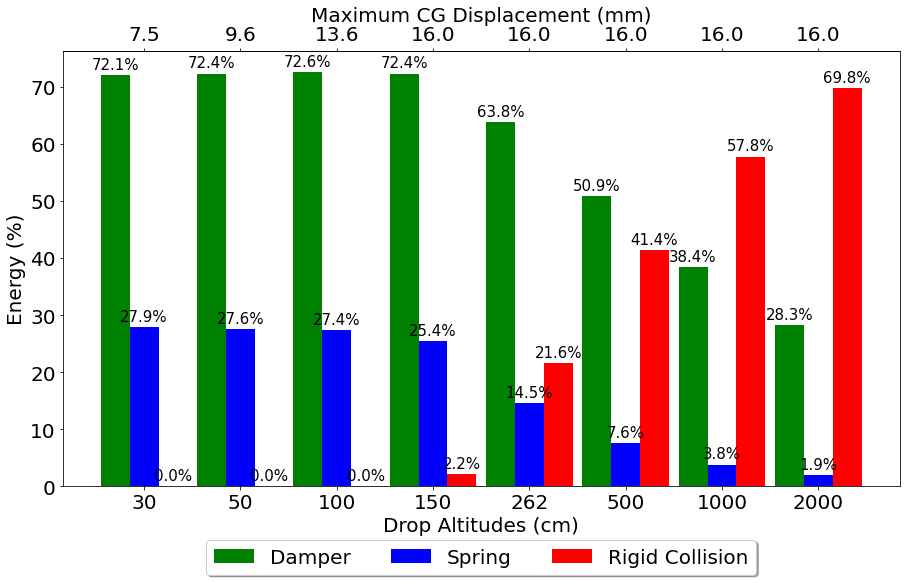

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
rects1 = ax.bar(ind - width, energies_diss, width, label='Damper', color='green')
rects2 = ax.bar(ind, energies_stor, width, label='Spring', color='blue')
rects3 = ax.bar(ind + width, energies_col, width, label='Rigid Collision', color='red')
    

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Energy (%)', fontsize=20)
ax.set_xlabel('Drop Altitudes (cm)', fontsize=20)
# ax.set_title('Energy when it reaches the maximum displacement')
ax.set_xticks(ind)
ax.set_xticklabels(altitudes)

# from https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html
def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.1f}%'.format(abs(height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom',
                    fontsize=15
                   )


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


secax = plt.gca().secondary_xaxis('top')
secax.set_xlabel('Maximum CG Displacement (mm)', fontsize=20)
xticks_labels = [""]
for h in altitudes:
    tmp = 1000*x_ss_cont(t_plot,cm,km,altitude=h/100,m=m).max()
    if tmp <= x_collision:
        xticks_labels.append(f"{tmp:.1f}")
    else:
        xticks_labels.append(f"{x_collision:.1f}")
secax.set_xticklabels(xticks_labels)

secax.tick_params(axis='both', which='major', labelsize=20)


plt.gca().tick_params(axis='both', which='major', labelsize=20)

# Shrink current axis's height by 10% on the bottom
# box = plt.gca().get_position()
# plt.gca().set_position([box.x0, box.y0 + box.height * 0.2,
#                  box.width, box.height * 0.8])

# Put a legend below current axis
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5, fontsize=20)

# fig.tight_layout()

plt.show()

# For the warning about FixedFormatter:
# https://stackoverflow.com/a/63755285

# Static spring constant identification

In [ ]:
# Spring constant comes from pressing the dynamometer against the top of the drone 
# and measuring the displacement in relation to the bottom

# Data collected:
FxD = [0.0, 3.6], [20, 3.5], [33, 3.3], [41, 3.1], [55, 3.0], [70, 2.7], [81, 2.5], [90, 2.3], [100, 2.1], [115, 2.0]

spring = np.array(FxD)
spring[:,1] = (3.6-spring[:,1])*10 # *10 to convert from cm to mm

kfit, bfit = np.polyfit(spring[:,1]/1000, spring[:,0], 1) # /1000 to convert from mm to m
kfit, bfit

(6375.0418200066915, 10.137169621947145)

In [ ]:
# The frame alone is 73g, motors are 5.7g each and properllers 1g each, 
# but when I was measuring k I didn't have anything attached besides the motors.
# I don't think the load on the center was 10N (F = m*g... m = 10/9.81 ~ 1kg?!?)
print(f"Y intersect from polyfit: {bfit:.3f}N; Weight over the central part of the drone: {((0.241-0.073-4*(.0057+.001))*9.81):.3f}N")

Y intersect from polyfit: 10.137N; Weight over the central part of the drone: 1.385N


In [ ]:
0.241*9.81 # worst scenario

2.36421

In [ ]:
#
# Here I'm considering the idea where the initial force is negligible and, therefore, the
# force must be zero when the displacement is zero.
#

def spring_fit(x, k):
    return x*k+0.241*9.81

ks, covs = curve_fit(spring_fit, spring[:,1]/1000, spring[:,0],
                       bounds=(0,10000),
                       method="trf",
                       loss="linear") # linear, soft_l1, huber, cauchy, arctan
        
ks

array([7040.33305493])

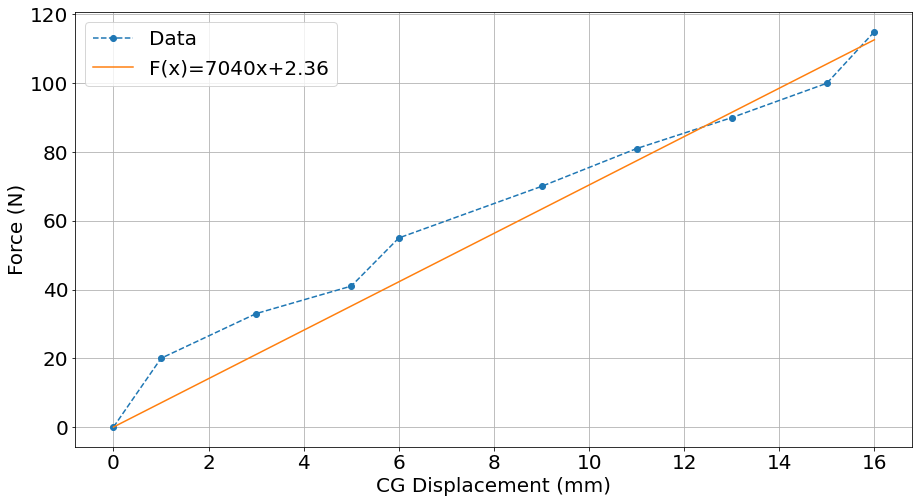

In [ ]:
x = np.linspace(0,spring[:,1].max()) # mm
plt.figure(figsize=(15,8))
plt.plot(spring[:,1],spring[:,0], 'o--', label="Data")
plt.plot(x, spring_fit(x,ks[0])/1000, '-', label=f"F(x)={ks[0]:.0f}x+{(0.241*9.81):.2f}")
plt.xlabel("CG Displacement (mm)",fontsize=20)
plt.ylabel("Force (N)",fontsize=20)
plt.grid()
# plt.title(f"Static Measurement using a Dynamometer",fontsize=20)
plt.legend(fontsize=20)
plt.gca().tick_params(axis='both', which='major', labelsize=20)
plt.show()

# Extra Plots

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
peaks = {}
for d,h,m in [("SoftBottom",50,0.241),("SoftBottom",100,0.241),("SoftBottom",150,0.241),("RigidBottom",30,0.239)]:
    peaks[h] = np.loadtxt(f"magnitude_accelerations_{d}_{h}cm_{int(m*1000)}g_fs_1kHz.csv").max(axis=1)

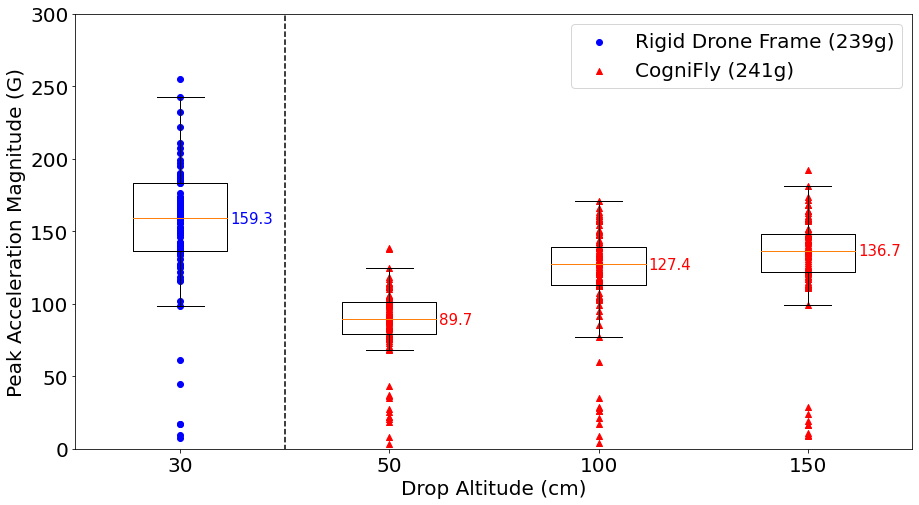

In [ ]:
keys = list(peaks.keys())
keys.sort()
data = [peaks[k] for k in keys]

plt.figure(figsize=(15,8))
plt.boxplot(data, labels=keys, showfliers=False)

plt.gca().annotate(f'{np.median(peaks[30]):.1f}',
            xy=(1, np.median(peaks[30])),
            xytext=(50, -5),  # use 3 points offset
            textcoords="offset points",  # in both directions
            fontsize=15, c="blue"
           )

for ai, arr in enumerate([peaks[50], peaks[100], peaks[150]]):
    plt.gca().annotate(f'{np.median(arr):.1f}',
                xy=(ai+2, np.median(arr)),
                xytext=(50, -5),  # use 3 points offset
                textcoords="offset points",  # in both directions
                fontsize=15, c="red"
               )


plt.scatter([1]*len(peaks[30]),peaks[30], c='blue', label="Rigid Drone Frame (239g)")
plt.scatter([2]*len(peaks[50]),peaks[50], marker='^', c='red', label="CogniFly (241g)")
plt.scatter([3]*len(peaks[100]),peaks[100], marker='^', c='red')
plt.scatter([4]*len(peaks[150]),peaks[150], marker='^', c='red')

ytcks = plt.gca().get_yticks()
plt.plot([1.5]*len(ytcks),ytcks,'k--')

plt.ylim(0,ytcks[-1])

# secax = plt.gca().secondary_xaxis('top')
# secax.set_xlabel('Gravitational Potential Energy at Drop ($Ep=mgh$) (J)')
# secax.set_xticks([1,2,3,4])
# secax.set_xticklabels([f"{0.3*9.81*.239:.1f}", f"{0.5*9.81*.241:.1f}", f"{1.0*9.81*.241:.1f}", f"{1.5*9.81*.241:.1f}"])

plt.gca().legend(fontsize=20)

plt.gca().tick_params(axis='both', which='major', labelsize=20)

plt.xlabel("Drop Altitude (cm)", fontsize=20)
plt.ylabel("Peak Acceleration Magnitude (G)", fontsize=20)
plt.show()

#  ($acc_{mag}=\sqrt{{acc_x}^2+{acc_y}^2+{acc_z}^2}$)

In [ ]:
# Number of trials for each experiment
[f"{str(i)}: {len(peaks[i])} trials" for i in [30,50,100,150]]

['30: 89 trials', '50: 101 trials', '100: 97 trials', '150: 89 trials']

In [ ]:
peaks[30].mean(), np.median(peaks[30]), peaks[150].mean(0), np.median(peaks[150])

(153.16814447736758, 159.25520774731538, 127.76107305482996, 136.718206431523)

In [ ]:
from scipy import stats

# Welch's t-test
# It assumes normal distributions, with different variance (not normally distributed here...)
stats.ttest_ind(peaks[30], peaks[150], equal_var = False), stats.ttest_ind(peaks[30]-100, peaks[150], equal_var = False), stats.ttest_ind(peaks[30], peaks[150]-100, equal_var = False)

(Ttest_indResult(statistic=4.003591838937344, pvalue=9.258480345734028e-05),
 Ttest_indResult(statistic=-11.754193748999075, pvalue=8.444232776824835e-24),
 Ttest_indResult(statistic=19.761377426873764, pvalue=3.777815908647031e-46))

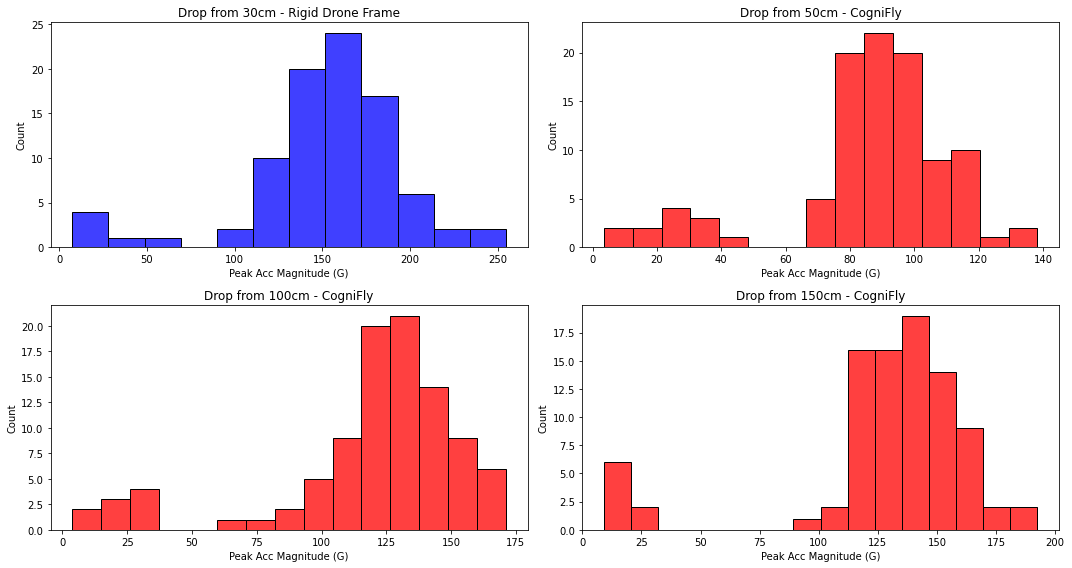

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
sns.histplot(peaks[30], color='blue')
plt.xlabel("Peak Acc Magnitude (G)")
plt.title("Drop from 30cm - Rigid Drone Frame")

plt.subplot(2,2,2)
sns.histplot(peaks[50], color='red')
plt.xlabel("Peak Acc Magnitude (G)")
plt.title("Drop from 50cm - CogniFly")

plt.subplot(2,2,3)
sns.histplot(peaks[100], color='red')
plt.xlabel("Peak Acc Magnitude (G)")
plt.title("Drop from 100cm - CogniFly")

plt.subplot(2,2,4)
sns.histplot(peaks[150], color='red')
plt.xlabel("Peak Acc Magnitude (G)")
plt.title("Drop from 150cm - CogniFly")
plt.tight_layout()
plt.show()

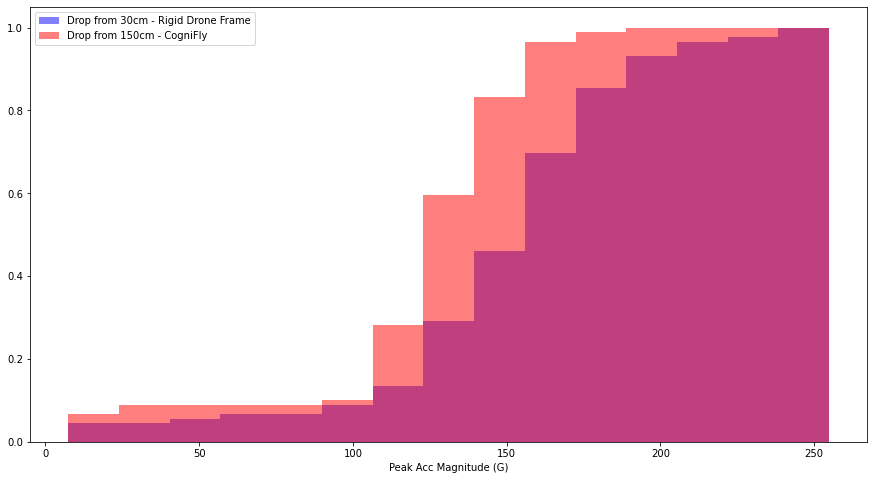

In [ ]:
plt.figure(figsize=(15,8))
bins=np.histogram(np.hstack((peaks[30],peaks[150])), bins=15)[1] #get the bin edges
plt.hist(peaks[30], color='blue', alpha=0.5, label="Drop from 30cm - Rigid Drone Frame", 
         bins=bins, density=True, cumulative=True)
plt.hist(peaks[150], color='red', alpha=0.5, label="Drop from 150cm - CogniFly", 
         bins=bins, density=True, cumulative=True)
plt.xlabel("Peak Acc Magnitude (G)")
plt.legend()

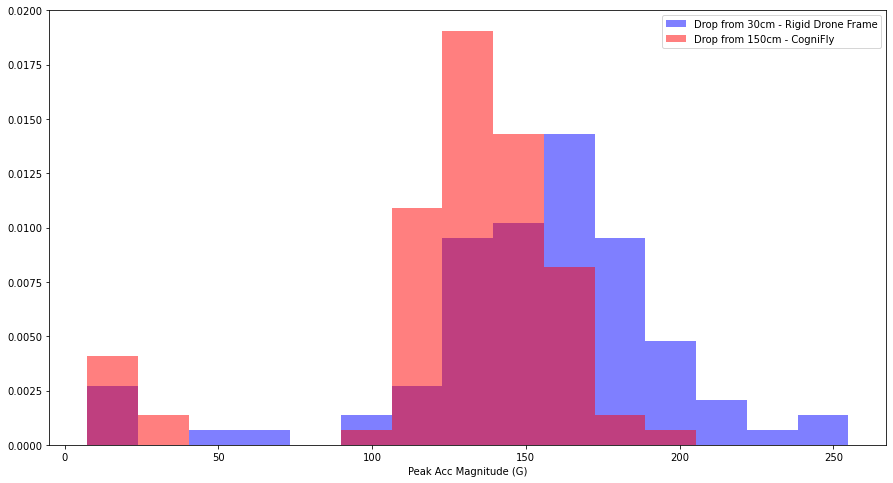

In [ ]:
plt.figure(figsize=(15,8))
bins=np.histogram(np.hstack((peaks[30],peaks[150])), bins=15)[1] #get the bin edges
plt.hist(peaks[30], color='blue', alpha=0.5, label="Drop from 30cm - Rigid Drone Frame", 
         bins=bins, density=True, cumulative=False)
plt.hist(peaks[150], color='red', alpha=0.5, label="Drop from 150cm - CogniFly", 
         bins=bins, density=True, cumulative=False)
plt.xlabel("Peak Acc Magnitude (G)")
plt.legend()



In [ ]:
from scipy.stats import ks_2samp

# Check if the distributions are the same
ks_2samp(peaks[30],peaks[150])

KstestResult(statistic=0.4044943820224719, pvalue=6.771992012340362e-07)

## c,k countour plot
It needs functions from [the optimization stage](#Optimization-to-fit-the-mass-spring-damper-model-to-the-experimental-data)

In [ ]:
from multiprocessing import Process, cpu_count, Array
from time import sleep

sizex = 200
sizey = 200

min_c = 0
max_c = 100

min_k = 0
max_k = 15000


def mse_calc(args):
    [shared_data,hi,h,ci,c,ki,k] = args 
    fs = 1000 # datalogger
    direction, m = "SoftBottom", 0.241
    with open(f"magnitude_accelerations_{direction}_{h}cm_{int(m*1000)}g_fs_{int(fs/1000)}kHz.csv") as f:
        resultant_accs = np.loadtxt(f)
    total = 0
    for acc in resultant_accs:
        acc *= 9.81 # because acc is in Gs
        argmax = np.argmax(acc) # index of the acceleration peak (from index_impact)
        acc = acc[:argmax]
        t = np.arange(len(acc))*(1/fs)
        total += (((func_fit(t, c, k, altitude=h, lp_cut=500) - acc)**2).sum())/len(acc) #MSE
    
    
    # There's no need to get the lock because each process writes to an unique position
    data = np.frombuffer(shared_data.get_obj()).reshape((3,sizey,sizex))
    data[hi,ki,ci] = total/len(resultant_accs) #the lengths are not the same, so it would be biased

c_values = np.linspace(min_c, max_c, sizex)
k_values = np.linspace(min_k, max_k, sizey)


z_all = np.zeros(3*sizex*sizey)
z_all_shared = Array('d', z_all)

In [ ]:
import sys
sys.getsizeof(z_all)/1_000_000, z_all.shape

(0.960096, (120000,))

In [ ]:
# Uncomment to generate new values (it will override the previous file...)

# max_processes = cpu_count()-2

# try:
#     p_list = []
#     total_points = 0
#     print_msg = z_all.shape[0]*0.05
#     for hi,h in enumerate([50,100,150]):
#         for ci,c in enumerate(c_values):
#             for ki,k in enumerate(k_values):
#                 total_points += 1
#                 if not (total_points % print_msg):
#                     print(f"Processing {hi,ci,ki}...   ", end = '')
#                 if len(p_list)<max_processes:
#                     p_list.append(Process(target=mse_calc, args=([z_all_shared,hi,h,ci,c,ki,k],)))
#                     p_list[-1].start()
#                 else:
#                     waiting = True
#                     while waiting:
#                         for pi,p in enumerate(p_list):
#                             if not p.is_alive():
#                                 p.terminate()
#                                 del p_list[pi]
#                                 p_list.append(Process(target=mse_calc, args=([z_all_shared,hi,h,ci,c,ki,k],)))
#                                 p_list[-1].start()
#                                 waiting = False
#                                 break
#                         sleep(0.1)

#     # Make sure all processes are done
#     for p in p_list:
#         p.join()

# except KeyboardInterrupt:
#     for p in p_list:
#         if p.is_alive():
#             print(f"Terminating {p.pid}...")
#             p.terminate()
#             print(f"Terminating {p.pid}... TERMINATED!")

# finally:
#     z = np.frombuffer(z_all_shared.get_obj()).reshape((3,sizey,sizex)).sum(axis=0)
#     #np.savetxt(f"countour_plot_c_{min_k}-{max_c}_k_{min_k}-{max_k}.csv", z)        

Processing (0, 29, 199)...   Processing (0, 59, 199)...   Processing (0, 89, 199)...   Processing (0, 119, 199)...   Processing (0, 149, 199)...   Processing (0, 179, 199)...   Processing (1, 9, 199)...   Processing (1, 39, 199)...   Processing (1, 69, 199)...   Processing (1, 99, 199)...   Processing (1, 129, 199)...   Processing (1, 159, 199)...   Processing (1, 189, 199)...   Processing (2, 19, 199)...   Processing (2, 49, 199)...   Processing (2, 79, 199)...   Processing (2, 109, 199)...   Processing (2, 139, 199)...   Processing (2, 169, 199)...   Processing (2, 199, 199)...   

Text(-35, -25, '(46, 7040)')

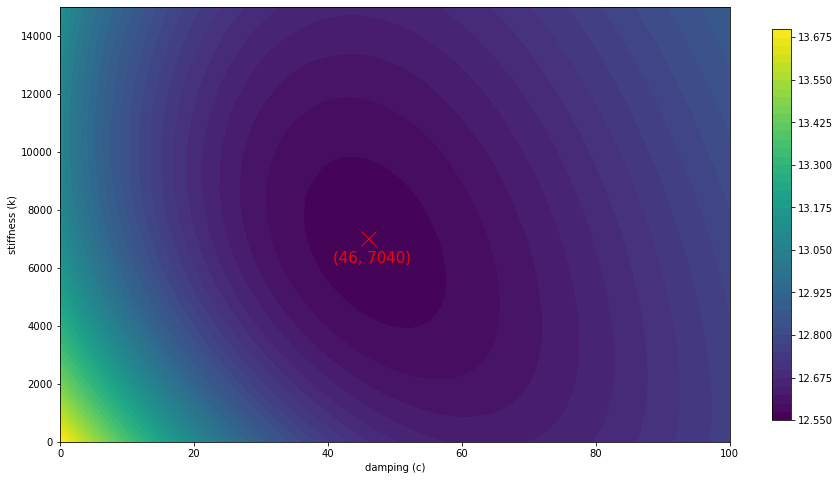

In [ ]:
# min_c = 0
# max_c = 50

# min_k = 0
# max_k = 10000

z = np.loadtxt(f"countour_plot_c_{min_k}-{max_c}_k_{min_k}-{max_k}.csv")

fig, ax = plt.subplots(figsize=(15,8))
# cs = ax.contourf(c_values,k_values,z)
cs = ax.contourf(c_values,k_values,np.log(1+z), levels=50) # log(1+z) => Cauchy loss
ax.set_xlabel("damping (c)")
ax.set_ylabel("stiffness (k)")
fig.colorbar(cs, ax=ax, shrink=0.9);
plt.plot([cm], [km],'rx',markersize=15);

plt.gca().annotate(f'{(cm,km)}',
            xy=(cm, km),
            xytext=(-35, -25),  # use 3 points offset
            textcoords="offset points",  # in both directions
            fontsize=15, c="red"
           )

In [ ]:
def func_minimize(args):
    c, k = args 
    if c < 0 or k < 0:
        return 100.
    
    total = 0
    for h in [50,100,150]:
        fs = 1000 # datalogger
        direction, m = "SoftBottom", 0.241
        g = 9.81
        with open(f"magnitude_accelerations_{direction}_{h}cm_{int(m*1000)}g_fs_{int(fs/1000)}kHz.csv") as f:
            resultant_accs = np.loadtxt(f)
        sub_total = 0
        for acc in resultant_accs:
            acc *= 9.81 # because acc is in Gs
            argmax = np.argmax(acc) # index of the acceleration peak (from index_impact)
            acc = acc[:argmax]
            t = np.arange(len(acc))*(1/fs)
            sub_total += (((func_fit(t, c, k, altitude=h, lp_cut=500) - acc)**2).sum())/len(acc) #MSE
    
        total += sub_total/len(resultant_accs) #the lengths are not the same, so it would be biased
        
    return np.log(1+total)

In [ ]:
from scipy.optimize import minimize

res = minimize(func_minimize, np.asarray([50.,7040.]), 
               method = 'Nelder-Mead')
               #method = 'Powell')
               #method = 'CG')

In [ ]:
res

   direc: array([[0.        , 1.        ],
       [0.05676523, 0.57885157]])
     fun: 12.559869129492116
 message: 'Optimization terminated successfully.'
    nfev: 52
     nit: 2
  status: 0
 success: True
       x: array([  46.31500979, 6996.12384851])

In [ ]:
results = func_minimize([46,7040]),func_minimize([46,6648]),func_minimize([46,6996])